In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize,Normalize
import numpy as np

In [3]:
from models.resnet_attn import Unet
image_size = 128
channels = 3
model = Unet(
    dim=128,
    channels=3,
    resnet_block_groups=8,
    use_convnext=False,
    dim_mults=(1, 2, 4,)
)

In [4]:
mean=torch.tensor([0.4850, 0.4560, 0.4060])
std=torch.tensor([0.2290, 0.2240, 0.2250])

In [5]:
postprocess = Compose([
     Lambda(lambda t: (t.cpu() * std.reshape(3,1,1))+mean.reshape(3,1,1)),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
     ToPILImage(),
])

In [6]:
@torch.no_grad()
def cos_diffusion_schedule(diffusion_times):
    # diffusion times -> angles
    min_signal_rate = torch.tensor(0.02).to(diffusion_times)
    max_signal_rate = torch.tensor(0.95).to(diffusion_times)
    start_angle = torch.acos(max_signal_rate)
    end_angle = torch.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    # angles -> signal and noise rates
    signal_rates = torch.cos(diffusion_angles).to(diffusion_times)
    noise_rates = torch.sin(diffusion_angles).to(diffusion_times)
    # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
    return noise_rates, signal_rates

In [7]:
import pytorch_lightning as pl
from ema_pytorch import EMA

class Diffusion(pl.LightningModule):

    def __init__(self, model, lr, weight_decay):
        super().__init__()
        
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        
        self.ema_network = EMA (
        self.model,
        beta = 0.999,              # exponential moving average factor
        update_after_step = 1,    # only after this number of .update() calls will it start updating
        update_every = 1,          # how often to actually update, to save on compute (updates every 10th .update() call)
        )
        self.gidx=1
    
    
    def denoise(self,noisy_images, noise_rates, signal_rates,training=True):
        # predict noise component and calculate the image component using it
        if training:
            network = self.model
        else:
            network = self.ema_network
        pred_noises = network(noisy_images, noise_rates.reshape((noise_rates.shape[0]),)**2)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images
    
    
    def forward(self, noisy_images, noisy_rates):
        outputs = self.model(noisy_images, noisy_rates)
        return outputs
    
    def losses(self,noise,predicted_noise, loss_type="l1"):
        if loss_type == 'l1':
            loss = F.l1_loss(noise, predicted_noise)
        elif loss_type == 'l2':
            loss = F.mse_loss(noise, predicted_noise)
        elif loss_type == "huber":
            loss = F.smooth_l1_loss(noise, predicted_noise)
        else:
            raise NotImplementedError()
        return loss
    
    @torch.no_grad()
    def get_noise(self,images):
        noises = torch.randn((batch_size,channels, image_size, image_size)).to(images)
        diffusion_times = torch.rand((batch_size,1,1,1)).to(images) 
        noise_rates, signal_rates = cos_diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        return noises,noise_rates,noisy_images,signal_rates
        
     
    def common_step(self, batch, batch_idx):
        images = batch["pixel_values"]
        noises,noise_rates, noisy_images,signal_rates=self.get_noise(images)
        pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates)
        noise_loss = self.losses(noises, pred_noises)
        image_loss = self.losses(images, pred_images)
        return noise_loss,{"NoiseLoss":noise_loss,"ImageLoss":image_loss}
    
    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        self.ema_network.update()
        return loss
    
    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss
    
    def validation_epoch_end(self,validation_step_outputs):
        self.eval()
        images=generate(self,24,200,device="cuda")
        rows=len(images)//4
        cols=len(images)//rows
        plt=plot_images(images,rows,cols)
        plt.savefig(os.path.join("./lightning_logs/simple_unet_celeb",f"{self.gidx}"+"_res.png"))
        self.train()
        self.gidx+=1

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [8]:
ckpt_file_path="lightning_logs/resnet_attnention/checkpoints/flowers_diffusion-epoch=197-validation_loss=0.1135.ckpt"
DModel= Diffusion.load_from_checkpoint(ckpt_file_path,model=model, lr=1e-3, weight_decay=0)

In [9]:
DModel.eval().cuda()

Diffusion(
  (model): Unet(
    (init_conv): Conv2d(3, 84, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=128, out_features=512, bias=True)
      (2): GELU()
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0): ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(84, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (res_conv): Conv2d(8

Diffusion(
  (model): Unet(
    (init_conv): Conv2d(3, 84, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): SinusoidalPositionEmbeddings()
      (1): Linear(in_features=128, out_features=512, bias=True)
      (2): GELU()
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0): ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=128, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(84, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (res_conv): Conv2d(8

In [10]:
@torch.no_grad()
def reverse_diffusion(model,initial_noise, diffusion_steps,device="cuda"):
    # reverse diffusion = sampling
    #print(next(model.parameters()).device)
    num_images = initial_noise.shape[0]
    step_size = 1.0 / diffusion_steps
    # important line:
    # at the first sampling step, the "noisy image" is pure noise
    # but its signal rate is assumed to be nonzero (min_signal_rate)
    next_noisy_images = initial_noise
    all_preds=[]
    for step in tqdm(range(diffusion_steps)):
        noisy_images = next_noisy_images
        # separate the current noisy image to its components
        diffusion_times = torch.ones((num_images,1,1,1)).to(device) - step * step_size
        diffusion_times=diffusion_times.to(initial_noise)
        noise_rates, signal_rates = cos_diffusion_schedule(diffusion_times)
        pred_noises, pred_images = model.denoise(noisy_images, noise_rates, signal_rates,training=False)
        # remix the predicted components using the next signal and noise rates
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = cos_diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        all_preds.append(pred_images)
        # this new noisy image will be used in the next step
        #next_noisy_images=pred_images
    # Last step
    #diffusion_times = torch.zeros((num_images,1,1,1)).to(device)
    #diffusion_times=diffusion_times.to(initial_noise)
    #noise_rates, signal_rates = cos_diffusion_schedule(diffusion_times)
    #pred_noises, pred_images = model.denoise(pred_images, noise_rates, signal_rates,training=False)
    
    return all_preds

In [11]:
@torch.no_grad()
def generate(model,num_images, diffusion_steps,device="cuda"):
    # noise -> images -> denormalized images
    initial_noise =torch.randn((num_images,channels, image_size, image_size)).to(device)
    #initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
    generated_images = reverse_diffusion(model,initial_noise, diffusion_steps)
    ims=[]
    for i in range(len(generated_images)):
        steps=[]
        images_steps=generated_images[i]
        for j in range(images_steps.shape[0]):
            steps.append(postprocess(images_steps[j]))
        ims.append(steps)
    return ims

In [12]:
images=generate(DModel,4,200,device="cuda")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [13]:
len(images[-1])

4

4

In [14]:
def plot_images(images,num_rows=3, num_cols=6):
    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(images[index])
            plt.axis("off")
    plt.tight_layout()
    #plt.show()
    #plt.close()

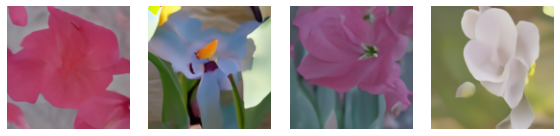

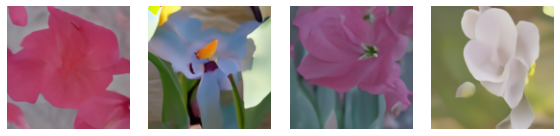

In [15]:
rows=len(images[-1])//4
cols=len(images[-1])//rows
plot_images(images[-1],rows,cols)

In [16]:
# pick index and plot images from diffusion

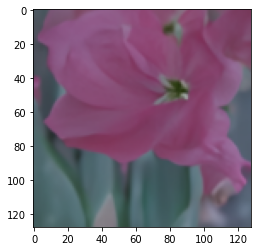

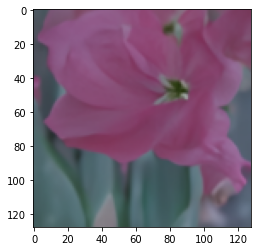

In [20]:
idx=2
animate_imgs=[]
for step_imgs in images:
    im = plt.imshow(step_imgs[idx], animated=True)
    animate_imgs.append([im])

In [21]:
import matplotlib.animation as animation
fig = plt.figure()
animate = animation.ArtistAnimation(fig, animate_imgs, interval=200, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [22]:
len(animate_imgs)

200

200

In [25]:
! sudo chmod -R 755
!conda install -c conda-forge ffmpeg

/bin/bash: /opt/conda/bin/conda: Permission denied
/bin/bash: /opt/conda/bin/conda: Permission denied
